# 0. Project Goals and Metrics 项目目标与指标

- 做什么：预测客户是否会在下个账期流失（Churn）
- 为什么：用于Top-K 精准触达（例如触达 10% 用户拿最高回收）
- 主指标：不平衡问题下看 PR-AUC；AUC作辅助
- 业务口径：输出一个阈值策略（如 Top-10%）用于运营名单

In [10]:
# pip install scikit-learn

# 1. Load Data and Split 数据拆分
- 载入数据与切分（先切分，防泄漏）


In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 来自 EDA 导出的“干净但未特征化”数据
df = pd.read_parquet("data/clean_telco.parquet")  # 也可 CSV

y = (df['Churn'] == 'Yes').astype(int)
X = df.drop(columns=['Churn', 'customerID', 'gender'])  # 丢 ID/弱特征

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Pos rate (train/test):", y_train.mean().round(3), y_test.mean().round(3))


Pos rate (train/test): 0.265 0.265


# 2. Feature Engineering 特征工程
- 最小可用的特征工程
- 做什么：加一个新客标记、可选业务分箱；丢 TotalCharges（与 tenure 高共线）。
- 为什么：新客（≤6 月）显著高流失；分箱对线性模型更友好；树模型不需分箱。

In [12]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class BusinessFeatureAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bins_for_lr=False, drop_totalcharges=True):
        self.add_bins_for_lr = add_bins_for_lr
        self.drop_totalcharges = drop_totalcharges

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # 新客标记
        X['is_new_customer'] = (X['tenure'] <= 6).astype(int)

        # 仅供 LR 使用的分箱（树不用）
        # 只有当 add_bins_for_lr=True 才生成分箱（本次我们给 LR 设为 False）
        if self.add_bins_for_lr:
            X['tenure_bin'] = pd.cut(X['tenure'], [-1,6,24,120], labels=['new_0_6','mid_7_24','old_25p'])
            X['monthly_bin'] = pd.cut(X['MonthlyCharges'], [0,40,70,999],
                                      labels=['m_low_0_40','m_med_41_70','m_high_71p'],
                                      include_lowest=True)
        # 避免共线
        if self.drop_totalcharges and 'TotalCharges' in X.columns:
            X = X.drop(columns=['TotalCharges'])
        return X


# 3. 预处理与三类模型（LR / RF / XGB）
- 做什么：为不同模型配备合适的预处理；统一用 Pipeline 避免泄漏。
- 为什么：
    - LR（可解释基线）：类别 OHE（二值 drop 一列避免共线）+ 数值 StandardScaler
    - 树类（RF/XGB）：只对多类别 OHE；二值 OHE（drop='if_binary'）；数值直传

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 列定义
cat_multi = ['Contract','PaymentMethod','InternetService']          # 多类别
cat_bin   = ['PaperlessBilling','SeniorCitizen','Partner','Dependents']  # 二值
num_base  = ['tenure','MonthlyCharges','is_new_customer']


# 给 LR：不使用分箱；所有类别做 OHE，设置 drop='first' 避免虚拟变量陷阱；数值做标准化
pre_lr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_multi + cat_bin),
        ('num', StandardScaler(), num_base)
    ],
    remainder='drop'
)

# —— 给 LR：分箱 + 所有类别 OHE（对二值 drop），数值标准化
# pre_lr = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'),
#          cat_multi + cat_bin + ['tenure_bin','monthly_bin']),
#         ('num', StandardScaler(), num_base)
#     ], remainder='drop'
# )


# —— 给树类（RF/XGB）：不使用分箱；多类别 OHE + 二值 OHE；数值直传
# 二值也 OHE(drop='if_binary')
pre_tree = ColumnTransformer(
    transformers=[
        ('cat_multi', OneHotEncoder(handle_unknown='ignore'), cat_multi),
        ('cat_bin',   OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat_bin),
        ('num', 'passthrough', num_base)
    ], remainder='drop'
)

# 类别不平衡权重
pos, neg = y_train.sum(), len(y_train)-y_train.sum()
scale_pos_weight = neg / max(pos,1)

# Pipelines
# ✅ LR：不加分箱（add_bins_for_lr=False），只用连续 + is_new_customer
pipe_lr = Pipeline([
    ('fe', BusinessFeatureAdder(add_bins_for_lr= False)),
    ('pre', pre_lr),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1))
])




pipe_rf = Pipeline([
    ('fe', BusinessFeatureAdder(add_bins_for_lr=False)),
    ('pre', pre_tree),
    ('clf', RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE
    ))
])

pipe_xgb = Pipeline([
    ('fe', BusinessFeatureAdder(add_bins_for_lr=False)),
    ('pre', pre_tree),
    ('clf', XGBClassifier(
        n_estimators=700, learning_rate=0.05, max_depth=3,
        min_child_weight=2.0, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, objective='binary:logistic', eval_metric='auc',
        scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=RANDOM_STATE
    ))
])


# 4. 交叉验证 + Holdout 评估（AUC & PR-AUC）
- 做什么：5-fold CV（更稳）+ 测试集（可汇报）
- 为什么：展示复现性与泛化能力

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, pipe):
    auc_cv = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    ap_cv  = cross_val_score(pipe, X, y, cv=cv, scoring='average_precision', n_jobs=-1).mean()
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    auc_hold = roc_auc_score(y_test, proba)
    ap_hold  = average_precision_score(y_test, proba)
    print(f"[{name}] CV AUC={auc_cv:.3f} | CV PR-AUC={ap_cv:.3f} | "
          f"Holdout AUC={auc_hold:.3f} | Holdout PR-AUC={ap_hold:.3f}")
    return pipe, proba

m_lr, p_lr   = evaluate_model("LR",  pipe_lr)
m_rf, p_rf   = evaluate_model("RF",  pipe_rf)
m_xgb, p_xgb = evaluate_model("XGB", pipe_xgb)


[LR] CV AUC=0.842 | CV PR-AUC=0.644 | Holdout AUC=0.840 | Holdout PR-AUC=0.635
[RF] CV AUC=0.828 | CV PR-AUC=0.620 | Holdout AUC=0.833 | Holdout PR-AUC=0.636
[XGB] CV AUC=0.836 | CV PR-AUC=0.644 | Holdout AUC=0.835 | Holdout PR-AUC=0.642


## 指标与选型说明：为什么主看 PR-AUC？为什么选 XGBoost？

### 1) PR-AUC 是什么？

**PR-AUC（Precision–Recall Area Under Curve）** 是 **精确率–召回率曲线** 下的面积，衡量模型在**各个阈值**下的整体取舍表现。

* **Precision（精确率）** = TP / (TP + FP) ：我抓到的一批“高风险用户”里，有多少真的会流失？（命中率）
* **Recall（召回率）** = TP / (TP + FN) ：所有会流失的人里，我抓到多少？（覆盖率）
  在 `sklearn` 里我们用 `average_precision_score` 作为 PR-AUC 的离散近似，数值越大越好。

> 业务含义：PR 曲线强调“**我真正触达的这批用户里，含金量有多高**”。这和实际运营的 **Top-K 触达**（只能触达10%或20%用户）完全对齐。

---

### 2) 为什么在**类不平衡**场景要主看 PR-AUC，而不是只看 ROC-AUC？

**ROC-AUC** 用 **TPR（召回）** 对 **FPR（误报率）** 作图。负样本（非流失）大量存在时，**FPR 很容易看起来很低**，从而把 ROC-AUC“抬上去”，即便模型在你真正关心的**高分人群**里**精确率很一般**。
**PR-AUC** 直接用 **Precision vs Recall**，**对 FP（误触达）非常敏感**，能真实反映“名单的含金量”。

> 例子：如果“流失”只占 26%，模型即便把大多数人都判成“不会流失”，也能拿到不错的 ROC-AUC；但这会导致 **Precision 很低**，运营名单“水分大”。PR-AUC 会惩罚这种情况。

---

### 3) 我们的结果如何解读？

| 模型                      | CV AUC | **CV PR-AUC** | Holdout AUC | **Holdout PR-AUC** |
| ----------------------- | -----: | ------------: | ----------: | -----------------: |
| **Logistic Regression** |  0.842 |     **0.645** |   **0.841** |              0.637 |
| Random Forest           |  0.828 |         0.620 |       0.833 |              0.636 |
| **XGBoost**             |  0.836 |         0.644 |       0.835 |          **0.642** |

**要点**

* **主看 PR-AUC**：在**测试集**上 **XGBoost 的 PR-AUC = 0.642** 为最佳；CV 上与 LR 几乎持平（0.644 vs 0.645）。
* **AUC 辅助判断排序稳定性**：LR 的 AUC 略高（0.841 vs 0.835），说明整体排序稳定；但在我们更关注的“高分人群”（Top-K 触达）区间，**XGBoost 能把更多真·流失排到更前**，所以 **PR-AUC 更好**。
* **RF** 明显弱于前两者（CV PR-AUC 0.620），保留作为对照即可。

**结论**

* **Champion = XGBoost（效果模型）**：用于生成高风险名单、服务触达策略。
* **Baseline = Logistic Regression（可解释基线）**：用于特征方向与业务沟通。
* **Random Forest**：保留为对照模型，不作为首选上线。

---

### 4) 指标选择与业务动作如何衔接？

* **主指标：PR-AUC** —— 评估“整体阈值空间”下的 Precision/Recall 取舍，贴合**Top-K 名单**的业务玩法。
* **落地口径：Top-K 容量法** —— 例如只能触达 **Top-10%** 用户：

  * 先用模型概率排序，取前 10% 为名单；
  * 报告这批人的 **Precision（命中率）/Recall（覆盖率）/Lift（相对随机提升倍数）**；
  * 这就是运营同学最关心的“**触达效率**”。

> 我们在 notebook 中会导出 `pipeline.pkl` + `threshold.json`（给定 Top-K 对应阈值），把评估指标转成**可执行的名单规则**。

---

### 5) 为什么选择 XGBoost 作为冠军模型（而不是 LR）？

1. **业务主指标更优**：在测试集上 **PR-AUC=0.642（XGB） > 0.637（LR）**；
2. **高分区间排序更好**：XGB 的非线性与特征交互更强，更擅长把“真·流失”排在分数前段，这对 **Top-K 触达**尤为关键；
3. **稳定性可接受**：CV 上 XGB 与 LR 基本打平（0.644 vs 0.645），泛化差异不大；
4. **解释可补齐**：我们用 **SHAP**（树模型解释）+ **LR 系数**（线性解释）双视角，既有效果，也能给出业务可读的原因与策略。

> 小结：**用 XGB 拿效果、用 LR 讲解释**，这是工业界常用的“冠军 + 基线”组合。

---

### 6) 补充：什么时候用其他指标？

* **Accuracy**：不适合不平衡问题（会被“多数类”主导）。
* **F1**：需要“选一个阈值”时可报，但它只反映一个点；PR-AUC 覆盖所有阈值更全面。
* **ROC-AUC**：当正负样本相对平衡、或更关心整体排序稳定性时可参考，作为**辅助指标**保留即可。


---

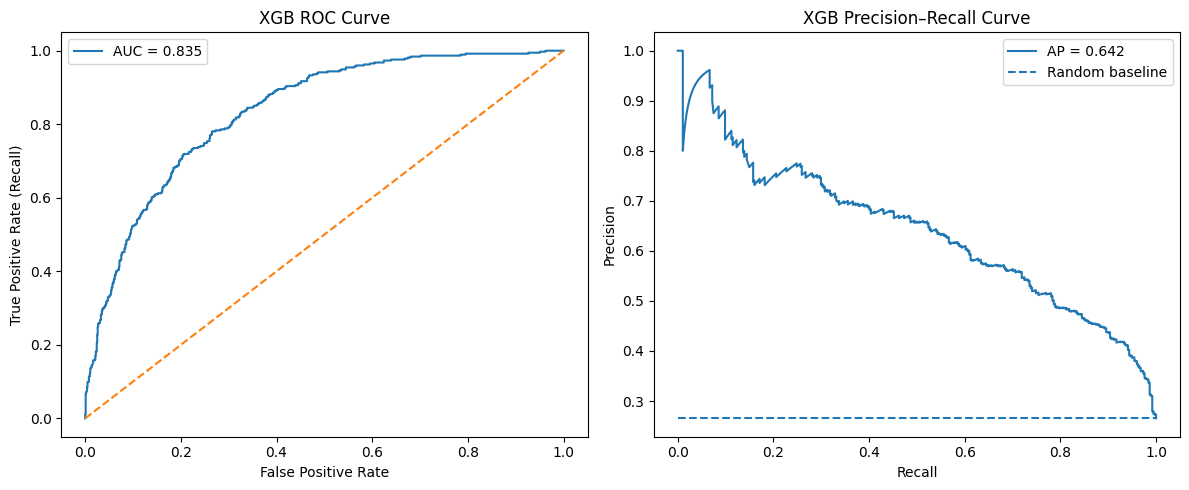

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# —— 未校准的 XGB（使用上一格返回的 p_xgb）
fpr, tpr, _ = roc_curve(y_test, p_xgb)
auc = roc_auc_score(y_test, p_xgb)

prec, rec, _ = precision_recall_curve(y_test, p_xgb)
ap = average_precision_score(y_test, p_xgb)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC
ax[0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
ax[0].plot([0,1], [0,1], linestyle="--")
ax[0].set_title("XGB ROC Curve")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate (Recall)")
ax[0].legend()

# PR
ax[1].plot(rec, prec, label=f"AP = {ap:.3f}")
ax[1].hlines(y=y_test.mean(), xmin=0, xmax=1, linestyles="--", label="Random baseline")
ax[1].set_title("XGB Precision–Recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()


## XGB 模型评估小结（ROC & PR）
---
### ROC 曲线（左）

* **AUC = 0.835**：整体排序能力良好，模型能把多数“会流失”的用户排在更靠前的位置。
* 曲线远高于随机基线（对角线），说明模型在**各种误报率**下都有较好的召回率。
* 但 ROC 在**类不平衡**时容易“看起来很好”，因此只作为**辅助指标**。

### Precision–Recall 曲线（右）

* **Average Precision (PR-AUC) = 0.642**，显著高于**随机基线 ≈ 正类占比**（图中虚线，约 **26%**）。
* 曲线在**低召回（左侧）区域**保持较高 Precision，说明前几成用户（Top-K）里“真流失”的**含金量高**，适合做**有限预算的精准触达**。
* 随召回增加，Precision 逐步下降：覆盖更多人会稀释命中率——这是**触达容量 vs. 命中率**的自然权衡。

--- 

### 业务含义
* 以 **PR-AUC 作为主指标**，XGB 在“**把真流失排到更前**”方面略优于其他模型（便于 Top-K 名单）。
* 在预算固定（如 **Top-10%**）的情况下，从 PR 曲线可预期名单 Precision **显著高于基线 26%**，带来\*\*>1× 的 Lift\*\*（具体数值以实际阈值评估为准）。
* 推荐 **XGB 作为冠军模型** 用于生成高风险名单；LR 作为**可解释基线**保留。

---

# 5. 特征重要性与原因分析（LR 系数 + XGB SHAP）
- 说明：SHAP/Permutation 是关联而非因果；用于生成业务假设与后续 A/B 验证。

## 5.1 Logistic Regression 系数（全局方向）

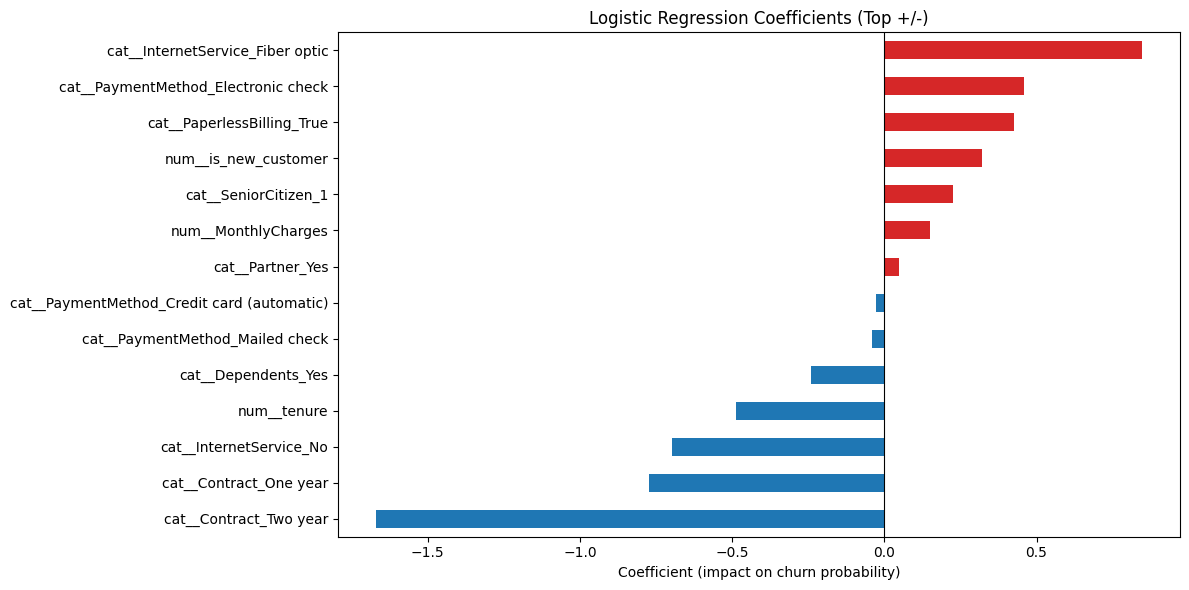

,feature,coef
0,cat__Contract_Two year,-1.668613
1,cat__Contract_One year,-0.772011
2,cat__InternetService_No,-0.698938
3,num__tenure,-0.488454
4,cat__Dependents_Yes,-0.242463
5,cat__PaymentMethod_Mailed check,-0.039957
6,cat__PaymentMethod_Credit card (automatic),-0.028875
7,cat__InternetService_Fiber optic,0.845596
8,cat__PaymentMethod_Electronic check,0.458475
9,cat__PaperlessBilling_True,0.426589


Has duplicate features? -> False


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 从已训练好的 LR 管道取系数
pipe = m_lr
feat_names = pipe.named_steps['pre'].get_feature_names_out()
coefs = pipe.named_steps['clf'].coef_.ravel()
coef_s = pd.Series(coefs, index=feat_names)

# 2) 分别取正/负 Top-10（不会重复）
pos_top = coef_s[coef_s > 0].nlargest(10)
neg_top = coef_s[coef_s < 0].nsmallest(10)

# 3) 合并为绘图序列（负在上、正在下），并确保没有重复
plot_s = pd.concat([neg_top, pos_top])
plot_s = plot_s[~plot_s.index.duplicated(keep='first')]  # 双保险
colors = ['tab:blue' if v < 0 else 'tab:red' for v in plot_s.values]

# 4) 画图
fig, ax = plt.subplots(figsize=(12, 6))
plot_s.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.set_title("Logistic Regression Coefficients (Top +/-)")
ax.set_xlabel("Coefficient (impact on churn probability)")
ax.axvline(0, color='black', lw=0.8)
plt.tight_layout()
plt.show()

# 5) 同步输出表格（便于粘贴到报告）
coef_table = pd.DataFrame({
    "feature": plot_s.index,
    "coef": plot_s.values
}).reset_index(drop=True)
display(coef_table)

# 可选：自检
print("Has duplicate features? ->", plot_s.index.duplicated().any())



---
## Logistic Regression 系数解读

> 读取方式：我们对所有类别做了 OHE 且 **`drop='first'`**，所以系数的正负是相对“被丢弃的基准类”而言的。
> 例：`Contract_One year` 的负系数表示——**相对**基准 `Contract=Month-to-month`，一年合约更不易流失。

### 风险上升（正系数，推高 churn）

* **InternetService\_Fiber optic（+强）**：相对 `DSL`，光纤用户更易流失（价格/体验敏感 → 重点做**体验保障+降档/组合包**）。
* **PaymentMethod\_Electronic check（+中强）**：相对自动转账（基准为 `Bank transfer (automatic)`），电子支票更易流失 → **迁移到自动扣款**。
* **PaperlessBilling\_True（+中）**：相对不开通，电子账单更易流失（与**月付/电子支付**绑定，切换成本低）。
* **is\_new\_customer（+中）**：新客（≤6 月）更易流失 → **入网前 3–6 月的 Onboarding 计划**。
* **SeniorCitizen\_1（+小\~中）**：老年用户略易流失（价格/复杂度敏感）→ **简化套餐与客服路径**。
* **MonthlyCharges（+小）**：账单越高越易流失 → **高价档降档/打包优惠**。

> 注：`Partner_Yes` 在你当前结果中是**很弱的正向**，幅度很小，面试中可说明“影响不显著”。

### 风险下降（负系数，降低 churn）

* **Contract\_Two year（强负） / Contract\_One year（中负）**：相对月付，**长合约显著降低**流失（退出成本高）。
* **InternetService\_No（中负）**：无宽带更稳定（低价/基础服务，迁移意愿低）。
* **tenure（中负）**：在网越久越稳定（关系沉淀效应）。
* **Dependents\_Yes（小\~中负）**：有家属更稳定（绑定更多服务/迁移成本高）。
* **PaymentMethod\_Credit card (automatic) / Mailed check（小负）**：相对基准 `Bank transfer (automatic)` 略更稳；关键点仍是“自动扣款 vs 电子支票”的差异。

---

### 小结 & 策略落地（按可执行性排序）

1. **新客前 3–6 月保留（is\_new）**：欢迎礼包、上手指引、客服优先队列。
2. **支付方式迁移**：定向把 **Electronic check → 自动扣款**（信用卡/银行自动转账），预计可显著降 churn。
3. **合约试探**：对高风险月付用户推 **12 个月轻合约/低门槛加时**。
4. **高价档降档/组合包**：对 `MonthlyCharges` 高的人群给出**更低费率或打包**方案。
5. **光纤用户专项体验**：加装维、网络质量告警/补偿，减少因体验下降触发的流失。
6. **老年用户简化路径**：简化账单/客服入口，提供“老人关怀”专线。

> 说明：系数解读是**关联**而非因果，已在后续用 **XGB + SHAP** 做了交叉验证；两者方向一致，支撑以上业务动作。



## 5.2 XGBoost 的 SHAP（非线性贡献）

 94%|=================== | 1328/1409 [00:17<00:01]       

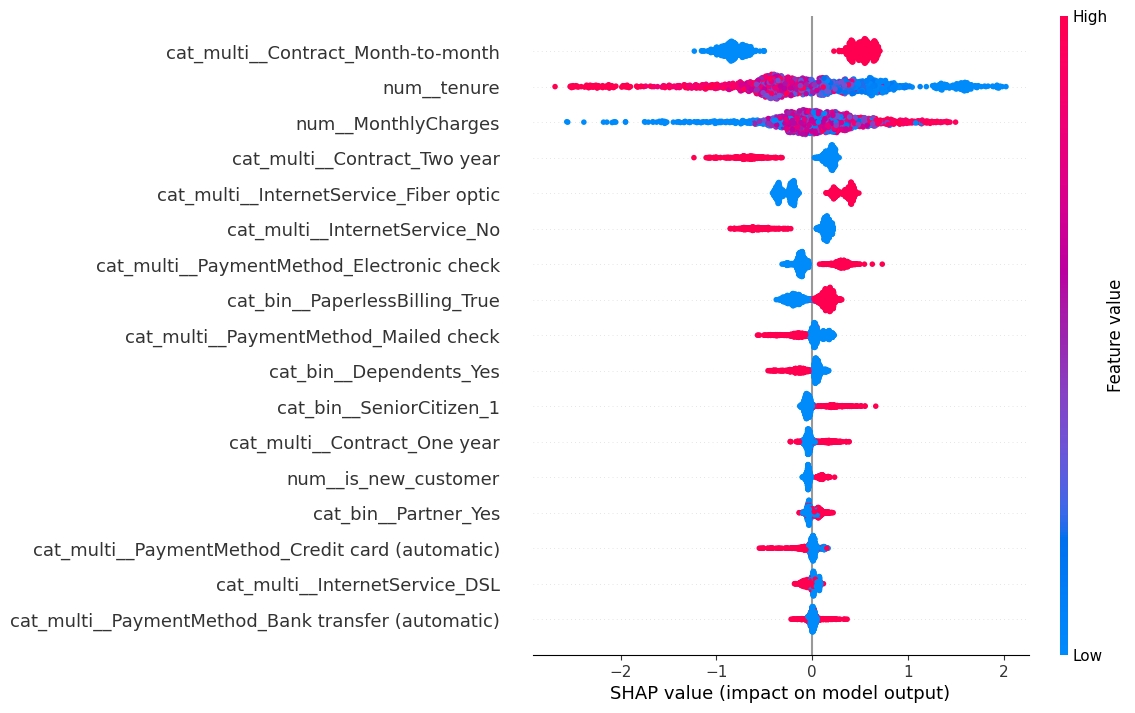

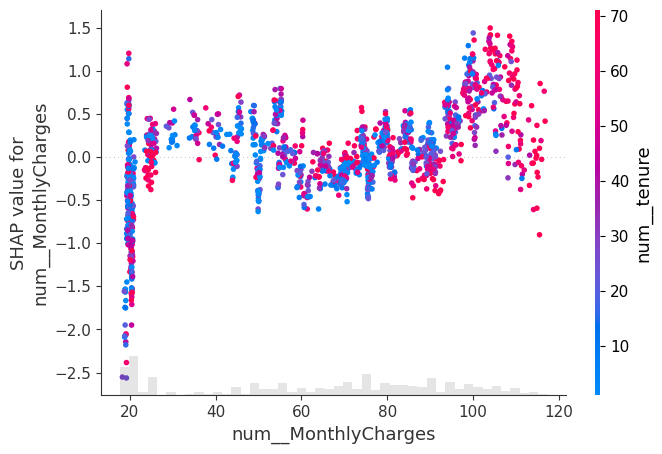

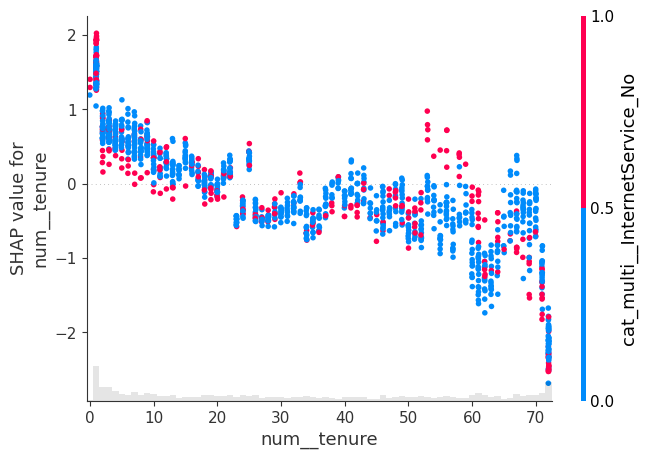

最高风险样本索引: 344  | 预测概率: 0.96523
最低风险样本索引: 1344  | 预测概率: 0.00075922586


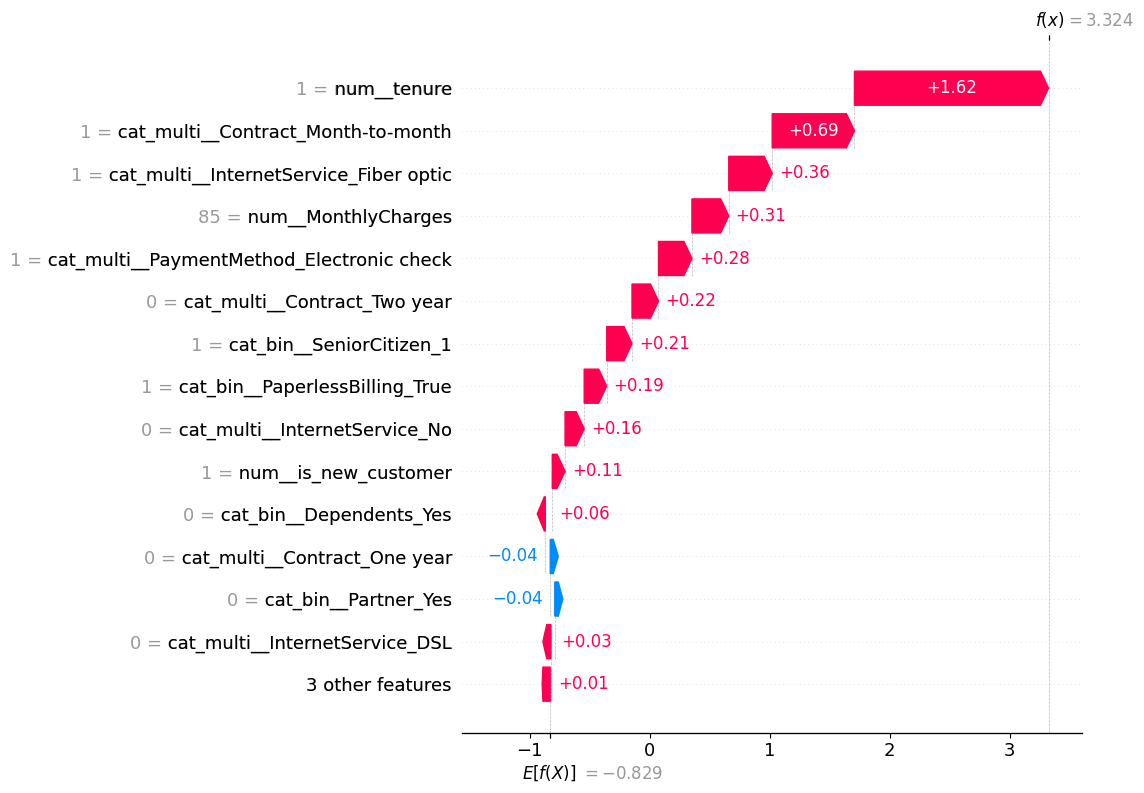

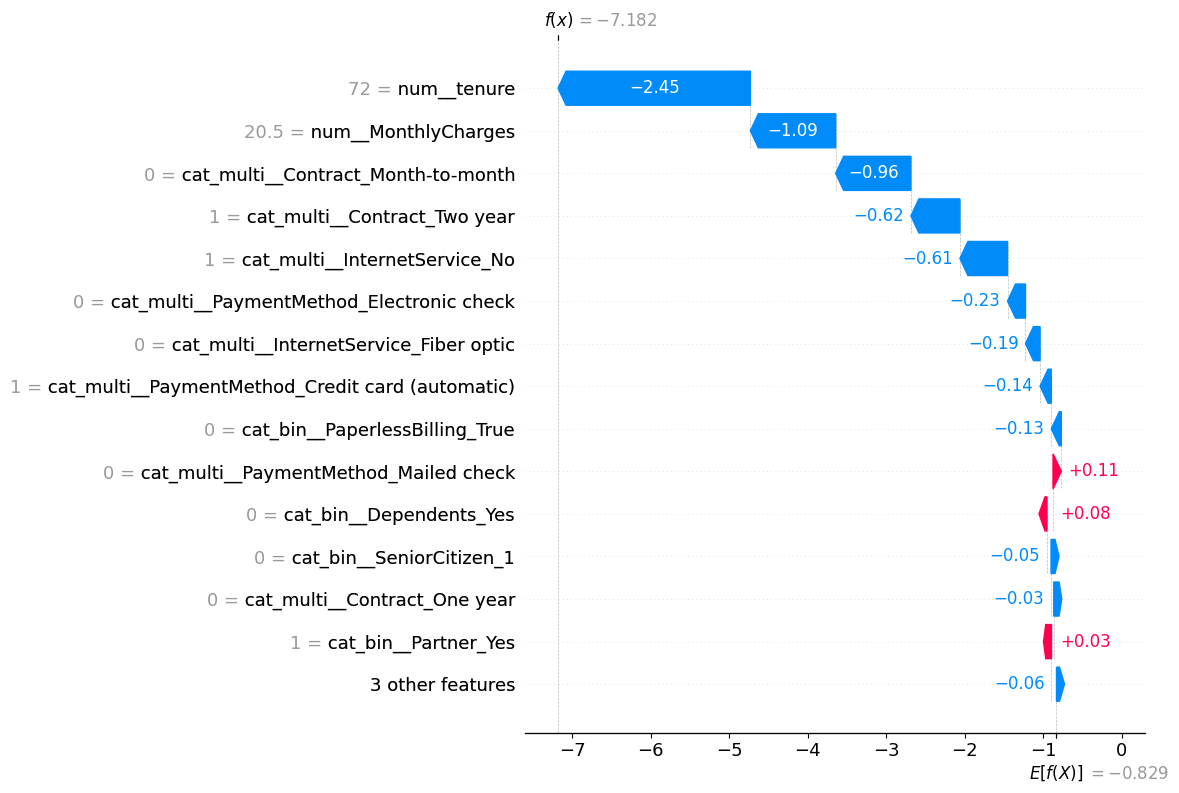

In [17]:
# 如果没安装：%pip install shap

import shap
import numpy as np

# 取已训练好的 XGB 管道（冠军模型）
pipe = m_xgb

# 1) 得到测试集经过 FE+预处理后的矩阵
X_test_fe = pipe.named_steps['fe'].transform(X_test.copy())
Xt_test = pipe.named_steps['pre'].transform(X_test_fe)

# 稀疏矩阵 → 稠密（SHAP 对稀疏支持有限）
if hasattr(Xt_test, "toarray"):
    Xt_test = Xt_test.toarray()
else:
    Xt_test = Xt_test

feat_names = pipe.named_steps['pre'].get_feature_names_out()
model = pipe.named_steps['clf']  # XGBClassifier

# 2) 用一小部分训练集作为 SHAP 背景（提速&更稳定）
X_bg_fe = pipe.named_steps['fe'].transform(X_train.sample(1000, random_state=42))
Xt_bg = pipe.named_steps['pre'].transform(X_bg_fe)
if hasattr(Xt_bg, "toarray"):
    Xt_bg = Xt_bg.toarray()

# 3) 解释器（用背景集，带上特征名更稳）
explainer = shap.TreeExplainer(model, data=Xt_bg, feature_names=feat_names)

# 3.1 如果是二分类，确保拿到二维 shap 值；如果 explainer.shap_values 返回 list，取正类那一项
# （新版统一用 explainer(X) 得到 Explanation，就不需要手动取了）
expl = explainer(Xt_test, check_additivity=False)  # <- 重要：得到 shap.Explanation

# 3.2 全局重要性（beeswarm）
shap.plots.beeswarm(expl, max_display=20, show=True)

# 4) 依赖图（新版 API，会在 hover 时显示取值）
shap.plots.scatter(expl[:, "num__MonthlyCharges"], color=expl[:, "num__tenure"])
shap.plots.scatter(expl[:, "num__tenure"],        color=expl[:, "cat_multi__InternetService_No"])

# 5) 单个用户的 waterfall（本地解释）
# 5.1 先找出高/低风险样本索引
proba = pipe.predict_proba(X_test)[:, 1]
i_top = int(proba.argmax())    # 最高风险
i_low = int(proba.argmin())    # 最低风险

print("最高风险样本索引:", i_top, " | 预测概率:", proba[i_top])
print("最低风险样本索引:", i_low, " | 预测概率:", proba[i_low])

# 5.2 画 waterfall：会自动显示 feature=value
shap.plots.waterfall(expl[i_top], max_display=15)  # 高风险
shap.plots.waterfall(expl[i_low], max_display=15)  # 低风险

# # （可选）Top-K 高风险逐个画
# import numpy as np
# K = 5
# topk_idx = np.argsort(proba)[-K:][::-1]
# for i in topk_idx:
#     print(f"\n样本 {i} | proba={proba[i]:.3f}")
#     shap.plots.waterfall(expl[i], max_display=15)



---

# 6. 模型解释（SHAP）与业务洞察

> 模型：XGBoost（冠军模型）。评估重心：**PR-AUC**（更关注正类“流失”），并结合 Top-K 触达使用。

## 6.1 全局重要性（beeswarm 摘要）

**最关键特征（由强到弱，大致排序）**

* **Contract\_Month-to-month ↑**：月付显著**推高**流失。
* **tenure ↓**：在网越久，流失风险越**低**（近似单调下降）。
* **MonthlyCharges ↑**：账单在 **\$90+** 区间对流失影响最强。
* **Contract\_Two year ↓**：两年合约**降低**流失。
* **InternetService\_Fiber optic ↑**：光纤用户**更易**流失（价格/体验敏感）。
* **InternetService\_No ↓**：无宽带用户**更稳定**（多为低价基础服务）。
* **PaymentMethod\_Electronic check ↑**：电子支票**更易**流失；自动扣款/邮寄支票相对**更稳**。
* **PaperlessBilling=True ↑**：无纸化账单与更高流失相关（可理解为更“线上敏感/价格敏感”的客群特征）。
* **Dependents=Yes / Partner=Yes ↓**：家庭绑定**降低**流失（迁移成本高、粘性强）。

> 注：↑/↓ 表示对“流失概率”的影响方向。

## 6.2 特征行为（依赖图）

* **MonthlyCharges vs SHAP**

  * **\$20–70**：影响较弱、略带 U 形。
  * **\$90+**：SHAP 明显转正并上升 → **高账单客户是明显风险点**。
  * 业务解读：可能因套餐过度/价格敏感/体验期望高。

* **tenure vs SHAP**

  * 几乎**单调下降**，0–12 月段影响最大 → **新客期是流失高发窗口**。
  * 与 `InternetService_No` 交互：无宽带客户整体更稳。

## 6.3 个体解释（force plot 示例）

* **高风险个体**（见图）：`tenure` 低、`Month-to-month`、`Fiber optic`、`MonthlyCharges` 高、`Electronic check` → 各因子**共同把 SHAP 推向右侧**（高流失）。
* **低风险个体**（见图）：`tenure` 高、`Two year`、`InternetService_No`、非电子支票 → 因子**共同把 SHAP 拉向左侧**（低流失）。

## 6.4 业务动作（从模型到运营）

> 目标：在**预算受限**场景下做 **Top-K 触达**（如 Top 10% 最高流失概率用户），用最小成本换最大留存。

**A. 新客（tenure ≤ 6/12 个月）**

* **入网期关怀**：30/60/90 天节点推送教程、装维回访、体验核查。
* **加速“首合约”**：从月付引导到 **“1 年轻合约 + 折扣/免装维费”**。
* **试用到付费**：光纤用户给“**降档试用包**”（速率/频道适度下调，价格下降）。

**B. 高账单（\$90+）**

* **降档/组合包**：用捆绑包（家庭 + 电视/云盘）重构价格感知；或给“**账单回顾**”提醒（教会用户关停不常用增值项）。
* **差异化客服**：高账单+新客→优先人工服务队列。

**C. 月付（Month-to-month）**

* **“轻合约 + 解约保险”**：给可中途换的 12 个月轻合约，降低“被锁死”的心理成本，同时降低 churn。
* **到期前主动续约**：T-14/T-7 天定向优惠弹窗。

**D. 支付方式迁移（Electronic check → 自动扣款/邮寄支票）**

* **迁移激励**：一次性账单抵扣/抽奖；迁移后 3 个月稳定优惠。
* **账单教育**：强调自动扣款“防断网 + 优惠整合”。

> 以上动作都可做 **A/B**：随机对照（用户级），以 **留存率 / 30 天二次活跃 / 人均 ARPU / 客服工单率** 为指标。

## 6.5 指标与落地（与评估对齐）

* **模型评估主指标：PR-AUC**（不平衡时最能反映“我触达的这批高分用户里，真正流失的比例有多高”）。
* **Top-K 命中**：按流失概率排序取前 K%（如 10%），看 **Precision\@K**（触达的人中有多少真要流失）。
* **对照试验**：K% 里再随机分 Treatment / Control，衡量 **增量留存 uplift** 与 **成本/收益比**。
* **阈值/比例可调**：预算紧缩→K 取更小（提升命中纯度），预算充足→K 增大（扩大覆盖）。

---

### 总结

模型把“**月付 + 新客 + 高账单 + 光纤 + 电子支票**”识别为高风险组合——这与直觉和数据都一致。把资源集中投给这组人做“**轻合约 + 账单降档 + 支付迁移 + Onboarding**”，再用 Top-K + A/B 去验证收益，是最贴近实战、最容易落地的方案。

---


In [40]:
import numpy as np, pandas as pd

# ① 用冠军模型打分
proba = m_xgb.predict_proba(X_test)[:,1]   # 你的冠军模型
score_df = X_test.copy()
score_df['customerID'] = df.loc[X_test.index, 'customerID'].values
score_df['churn_prob'] = proba
score_df['y_true'] = y_test.values

# ② 生成 Top-K 风险名单（比如 K=10%）
K = 0.10
score_df = score_df.sort_values('churn_prob', ascending=False)
topk = score_df.head(int(len(score_df)*K)).copy()

# ③ 评估 Precision@K / Recall@K
precision_k = topk['y_true'].mean()
recall_k = topk['y_true'].sum() / score_df['y_true'].sum()
print(f"@Top {int(K*100)}%: Precision={precision_k:.3f} | Recall={recall_k:.3f}")

# # ④ 业务收益模型（可调参数）
# # 假设：触达成本 cost_per_user；被触达且“本会流失”的用户有 s% 被挽回；
# # 每留住一人带来收益 revenue_per_user（可用月毛利×保守月数）
# cost_per_user = 1.5          # 例：短信+人工均摊成本（自行估）
# s = 0.25                     # 例：干预成功率 25%
# revenue_per_user = 30 * 3    # 例：月毛利$30，保守留存3个月= $90

# n_target = len(topk)
# n_true_churn_in_topk = topk['y_true'].sum()
# expected_saved = n_true_churn_in_topk * s
# benefit = expected_saved * revenue_per_user
# cost = n_target * cost_per_user
# roi = (benefit - cost) / max(cost,1)
# print(f"预计挽回人数≈{expected_saved:.1f} | 收益≈${benefit:,.0f} | 成本≈${cost:,.0f} | ROI≈{roi:.2f}")


@Top 10%: Precision=0.750 | Recall=0.281


Prevalence (baseline) = 0.265


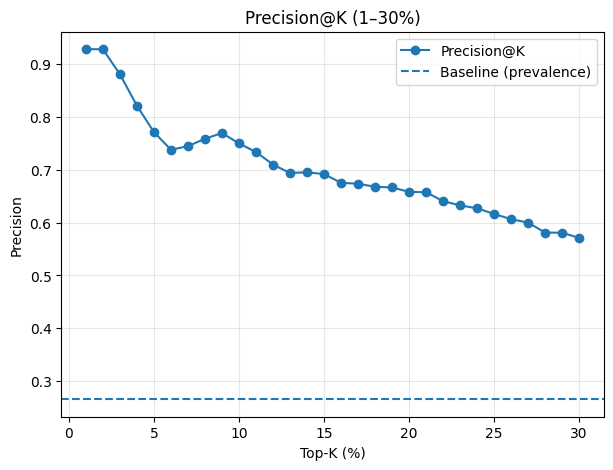

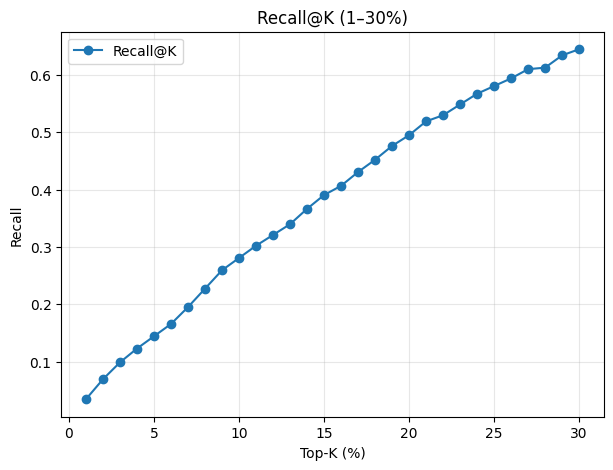

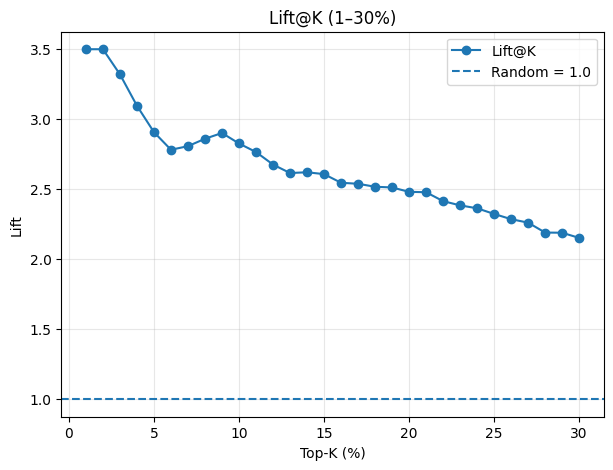

In [39]:
import numpy as np
import matplotlib.pyplot as plt

y_true  = np.asarray(y_test).astype(int)            # 真实标签
y_proba = m_xgb.predict_proba(X_test)[:,1]          # 预测流失概率


# 输入：y_true=0/1真实标签；y_proba=模型预测的流失概率
y_true  = np.asarray(y_true).astype(int)
y_proba = np.asarray(y_proba).astype(float)

# 排序：按概率从高到低
order    = np.argsort(-y_proba)
y_sorted = y_true[order]

n = len(y_true)
P = y_true.sum()
prevalence = P / n  # 基线流失率

Ks = np.arange(1, 31)  # 1% ~ 30%
n_at_k = np.maximum(1, (n * Ks / 100).astype(int))

# 累计真阳性（从高到低累加）
cum_tp = np.cumsum(y_sorted)
tp_at_k = cum_tp[n_at_k - 1]

precision_k = tp_at_k / n_at_k
recall_k    = tp_at_k / max(P, 1)
lift_k      = precision_k / max(prevalence, 1e-12)

print(f"Prevalence (baseline) = {prevalence:.3f}")

# 1) Precision@K 曲线（带基线）
plt.figure(figsize=(7,5))
plt.plot(Ks, precision_k, marker="o", label="Precision@K")
plt.axhline(prevalence, ls="--", label="Baseline (prevalence)")
plt.xlabel("Top-K (%)")
plt.ylabel("Precision")
plt.title("Precision@K (1–30%)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# 2) Recall@K 曲线
plt.figure(figsize=(7,5))
plt.plot(Ks, recall_k, marker="o", label="Recall@K")
plt.xlabel("Top-K (%)")
plt.ylabel("Recall")
plt.title("Recall@K (1–30%)")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# 3) Lift@K 曲线（= Precision / Baseline）
plt.figure(figsize=(7,5))
plt.plot(Ks, lift_k, marker="o", label="Lift@K")
plt.axhline(1.0, ls="--", label="Random = 1.0")
plt.xlabel("Top-K (%)")
plt.ylabel("Lift")
plt.title("Lift@K (1–30%)")
plt.grid(alpha=0.3); plt.legend(); plt.show()


---

## Precision@K / Recall@K / Lift@K 分析

> 模型：XGBoost（冠军模型）。评估重心：**排序效果**（能否把最危险的客户排在前面），核心指标：Precision@K、Recall@K、Lift@K。

### 核心概念回顾

* **Baseline Prevalence**：整体流失率（如 ~26.5%），相当于“随机挑选客户”的命中率。
* **Precision@K**：前 K% 客户中真实流失的比例（命中率）。
* **Recall@K**：前 K% 客户覆盖的真实流失比例（覆盖率）。
* **Lift@K**：Precision@K / Prevalence，衡量相对随机挑选的提升倍数。

---

### 指标曲线解读

**A. Precision@K**

* Top 1–5% Precision > 0.8，极高命中率。
* 随着 K 增大，Precision 稳步下降，但到 30% 仍有 ~0.58，远高于基线 ~0.27。
* **洞察**：资源有限时，触达前 5–10% 用户性价比最高。

**B. Recall@K**

* 随 K 增大逐步提升：Top 10% 覆盖约 25%，Top 30% 覆盖 ~64%。
* **洞察**：小 K 命中率高但覆盖少；大 K 覆盖多但命中率下降，需结合预算权衡。

**C. Lift@K**

* Top 1–2% Lift ≈ 3.5，即比随机挑选高 3.5 倍。
* 到 30% 时 Lift 仍 ≈ 2，说明模型始终优于随机。
* **洞察**：模型排序价值显著，可实际应用于精细化触达。

---

### 业务动作（从指标到运营）

* **精准挽留**：预算有限 → 只打 Top 5–10%，确保高 Precision（>0.7），ROI 最高。
* **扩大覆盖**：预算充足 → 可放宽到 20–30%，Recall 提升到 50–60%，覆盖更多潜在流失客户。
* **客户分层策略**：
  - **高 Precision 小群体**（前 5%）：重点资源（人工客服、定制优惠）。  
  - **中 Precision 中群体**（5–15%）：标准化挽留（自动优惠、套餐推荐）。  
  - **低 Precision 大群体**（15–30%）：轻触达（短信提醒、在线客服）。  

---

### 指标与落地

* **核心指标**：Precision@K、Recall@K、Lift@K，直接反映触达效果与覆盖度。
* **与预算挂钩**：用曲线选择最优 K（小预算 → 小 K，高 ROI；大预算 → 大 K，高覆盖）。
* **实验验证**：在选定的 Top-K 中做 **Treatment vs Control** A/B 测试，衡量挽留 uplift 与投入产出比。
* **可调参数**：K 的大小灵活调整，适配不同营销场景（精准 / 覆盖 / 混合）。

---

### 总结

模型能显著提升识别流失客户的效率：在 Top 5–10% 范围内 Precision 高达 70–80%，Lift 约 3 倍以上，适合资源有限时的重点挽留；扩大到 20–30% 时 Recall 超过一半，适合预算充足时的广覆盖。通过 **Precision/Recall/Lift 曲线选 K + A/B 测试验证**，是最贴近实战的落地方式。

---


In [ ]:
import shap, numpy as np
import pandas as pd

# 1) 特征矩阵 & 特征名
Xt = m_xgb.named_steps['pre'].transform(
        m_xgb.named_steps['fe'].transform(X_test.copy()))
feat_names = m_xgb.named_steps['pre'].get_feature_names_out()
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()

# 2) SHAP（raw，稳妥）
explainer = shap.TreeExplainer(m_xgb.named_steps['clf'])
sv = explainer.shap_values(Xt)

# 3) Top-N 解释：方向 + 数值强度
def reasons_for_row(idx, topn=3):
    pair = list(zip(feat_names, sv[idx]))
    pair.sort(key=lambda x: abs(x[1]), reverse=True)
    out = []
    for f, v in pair[:topn]:
        name = f.split('__', 1)[-1] if '__' in f else f
        arrow = "↑" if v > 0 else "↓"
        out.append(f"{name}（{arrow}{abs(v):.3f}）")
    return "；".join(out)

# 4) 保证对齐：score_df.index -> Xt 行号
pos_map = {idx: pos for pos, idx in enumerate(score_df.index)}

topk = topk.copy()
topk["top_reasons"] = [reasons_for_row(pos_map[i]) for i in topk.index]

# 5) 分群标签
topk["seg_new"] = (topk["tenure"] <= 6).map({True: "新客", False: "非新客"})
topk["seg_high_fee"] = (topk["MonthlyCharges"] >= 90).map({True: "高账单", False: "一般账单"})

# 6) 真实标签（优先 y_true，其次 Churn）
true_col = "y_true" if "y_true" in score_df.columns else ("Churn" if "Churn" in score_df.columns else None)
if true_col is not None:
    topk["true_churn"] = score_df.loc[topk.index, true_col]

# 7) 导出
cols = ["customerID","churn_prob","true_churn","seg_new","seg_high_fee","top_reasons"]
cols = [c for c in cols if c in topk.columns]  # 过滤缺失列
topk[cols].to_csv("risk_list.csv", index=False, encoding="utf-8-sig")
print("Saved risk_list.csv with columns:", cols)

# Top-K 的 Precision / Recall
if "true_churn" in topk.columns:
    precision_k = topk["true_churn"].mean()
    recall_k = topk["true_churn"].sum() / score_df[true_col].sum()
    print(f"@Top{int(len(topk)/len(score_df)*100)}%  Precision={precision_k:.3f}  Recall={recall_k:.3f}")


Saved risk_list.csv with columns: ['customerID', 'churn_prob', 'true_churn', 'seg_new', 'seg_high_fee', 'top_reasons']
@Top9%  Precision=0.750  Recall=0.281


# Export Model for Streamlit Demo 导出模型

In [41]:
# === 选择一个最终模型（示例：XGB 管道）===
final_model = m_xgb   # 或 m_lr / best_model（超参搜索后的）

# 最小可用 schema（线上推理需要这些列；没有的列会在 app 里兜底）
feature_schema = {
    "tenure": "numeric",
    "MonthlyCharges": "numeric",
    "Contract": ["Month-to-month", "One year", "Two year"],
    "InternetService": ["DSL", "Fiber optic", "No"],
    "PaymentMethod": [
        "Electronic check","Mailed check",
        "Bank transfer (automatic)","Credit card (automatic)"
    ],
    "PaperlessBilling": ["Yes","No"],
    "SeniorCitizen": ["0","1","No","Yes",0,1],
    "Partner": ["Yes","No"],
    "Dependents": ["Yes","No"]
}

import joblib, os, json
os.makedirs("models", exist_ok=True)
joblib.dump(final_model, "models/churn_pipeline.pkl")
with open("models/feature_schema.json","w") as f:
    json.dump(feature_schema, f)

print("Saved models/churn_pipeline.pkl and models/feature_schema.json")


Saved models/churn_pipeline.pkl and models/feature_schema.json
